## Data Preparation

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

In [2]:
PATH = 'KITTI_unet/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    target = tf.io.read_file(image_file)
    target = tf.image.decode_jpeg(target)
    
    target = tf.image.resize(target, (IMG_HEIGHT, IMG_WIDTH))    
    
    # make input
    low_res = tf.identity(target)
    low_res = tf.image.resize(low_res, (IMG_HEIGHT//8, IMG_WIDTH//8))

    return low_res, target 

(32, 128, 3)


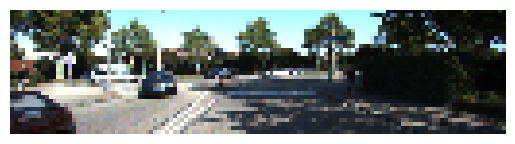

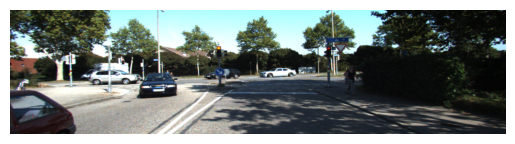

In [4]:
noisy_image, clean_image = load(PATH+'training/000008_10.png')
print(noisy_image.shape)

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(noisy_image/255.0)

plt.figure()
plt.axis('off')
plt.imshow(clean_image/255.0)

In [5]:
# normalizing the images to [-1, 1]
def normalize(noisy_image, clean_image):
    noisy_image = (noisy_image / 127.5) - 1
    clean_image = (clean_image / 127.5) - 1

    return noisy_image, clean_image

def random_jitter(noisy_image, clean_image):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        noisy_image = tf.image.flip_left_right(noisy_image)
        clean_image = tf.image.flip_left_right(clean_image)

    return noisy_image, clean_image

def load_image_train(image_file):
    noisy_image, clean_image = load(image_file)
    noisy_image, clean_image = random_jitter(noisy_image, clean_image)
    noisy_image, clean_image = normalize(noisy_image, clean_image)

    return noisy_image, clean_image

def load_image_test(image_file):
    noisy_image, clean_image = load(image_file)
    noisy_image, clean_image = normalize(noisy_image, clean_image)

    return noisy_image, clean_image

In [6]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'training/0000*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'testing/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:

# create funtion add 2 number


In [17]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Low Resolution', 'True High Resolution', 'Predicted High Resolution']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            
        plt.axis('off')
    plt.show()

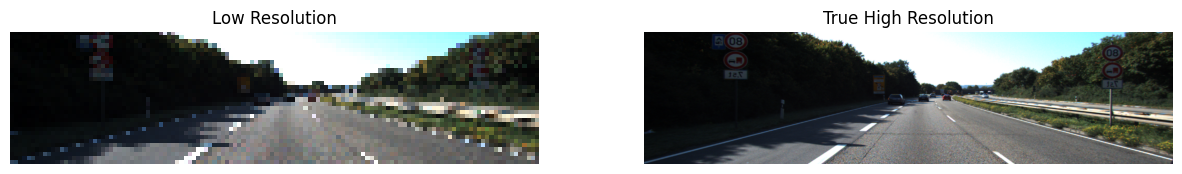

In [18]:
for noisy_image, clean_image in train_dataset.take(1):    
    sample_noisy_image, sample_clean_image = noisy_image[0], clean_image[0]
    display([sample_noisy_image, sample_clean_image])

## Model

In [14]:
inputs = tf.keras.layers.Input(shape=[32, 128, 3])    
x = inputs  

# block 1
x = tf.keras.layers.Conv2D(128, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre1 = x

# block 2
x = tf.keras.layers.Conv2D(256, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre2 = x

# block 3
x = tf.keras.layers.Conv2D(512, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

pre3 = x


# block 4
x = tf.keras.layers.Conv2D(1024, 4, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)


# upsampling
x = tf.keras.layers.Conv2DTranspose(512, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre3])

# upsampling
x = tf.keras.layers.Conv2DTranspose(256, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre2])

# upsampling
x = tf.keras.layers.Conv2DTranspose(128, 4, padding='same', strides=2, activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([x, pre1])

# upsampling
x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='LeakyReLU')(x)

x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='LeakyReLU')(x)

x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='LeakyReLU')(x)

x = tf.keras.layers.Conv2DTranspose(16, 4, strides=2, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.Conv2D(3, 3, padding='same', activation='tanh')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 128, 128  6272        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 32, 128, 128  512        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

 conv2d_transpose_25 (Conv2DTra  (None, 256, 1024, 1  8208       ['conv2d_26[0][0]']              
 nspose)                        6)                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 1024, 3  435         ['conv2d_transpose_25[0][0]']    
                                )                                                                 
                                                                                                  
Total params: 22,668,931
Trainable params: 22,663,299
Non-trainable params: 5,632
__________________________________________________________________________________________________


## Train

In [15]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

def show_predictions(dataset=None, num=1):
    predicted_image = model.predict(sample_noisy_image[tf.newaxis, ...])
    display([sample_noisy_image, sample_clean_image, predicted_image[0]])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0517

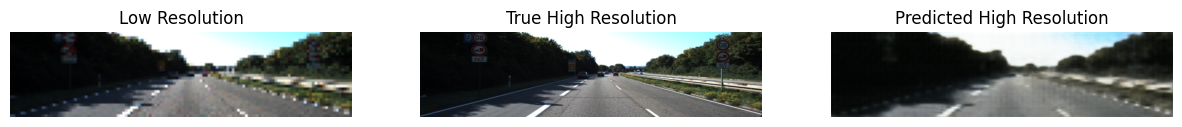


Sample Prediction after epoch 1

100/100 [==============================] - 2s 23ms/step - loss: 0.0515
Epoch 2/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0530

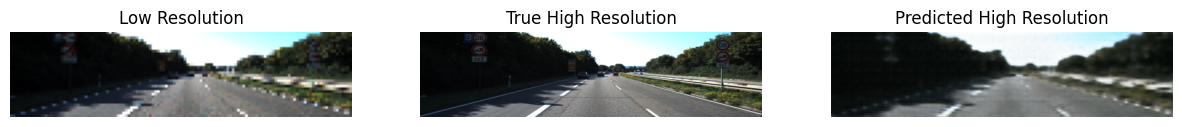


Sample Prediction after epoch 2

100/100 [==============================] - 2s 23ms/step - loss: 0.0529
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0505

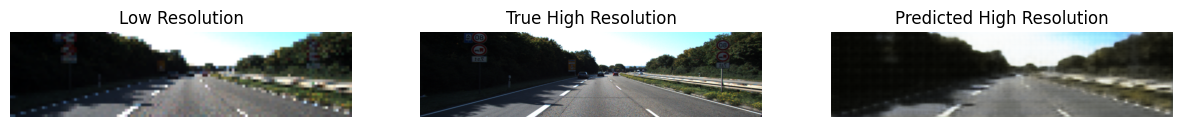


Sample Prediction after epoch 3

100/100 [==============================] - 2s 23ms/step - loss: 0.0505
Epoch 4/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0491

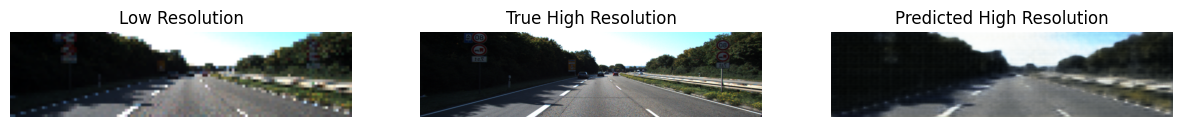


Sample Prediction after epoch 4

100/100 [==============================] - 2s 23ms/step - loss: 0.0490
Epoch 5/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0503

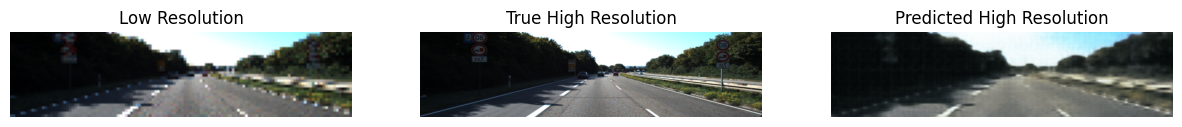


Sample Prediction after epoch 5

100/100 [==============================] - 2s 23ms/step - loss: 0.0503
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 0.0469

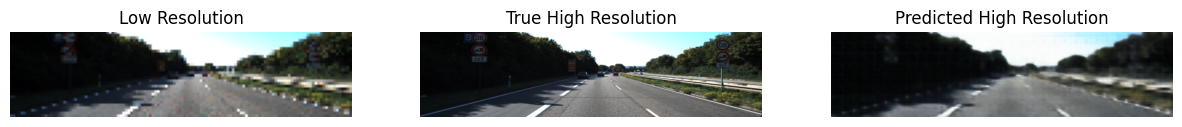


Sample Prediction after epoch 6

100/100 [==============================] - 3s 24ms/step - loss: 0.0469
Epoch 7/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0450

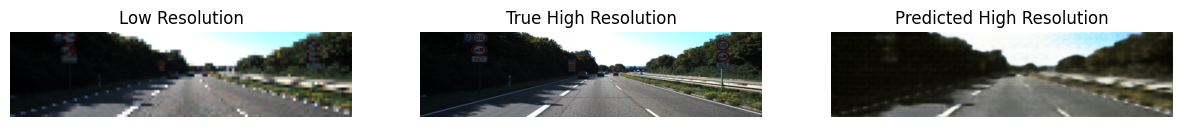


Sample Prediction after epoch 7

100/100 [==============================] - 2s 23ms/step - loss: 0.0451
Epoch 8/20
100/100 [==============================] - ETA: 0s - loss: 0.0455

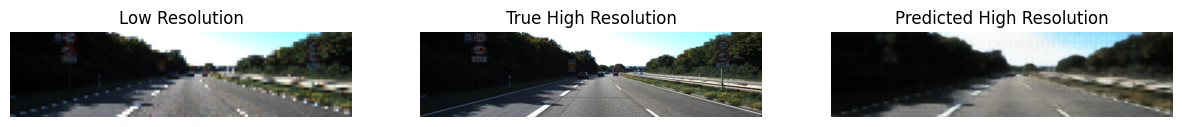


Sample Prediction after epoch 8

100/100 [==============================] - 2s 23ms/step - loss: 0.0455
Epoch 9/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0443

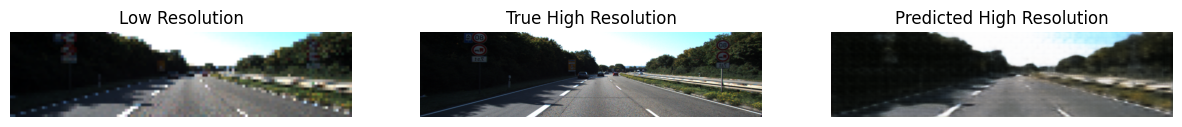


Sample Prediction after epoch 9

100/100 [==============================] - 2s 23ms/step - loss: 0.0442
Epoch 10/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0451

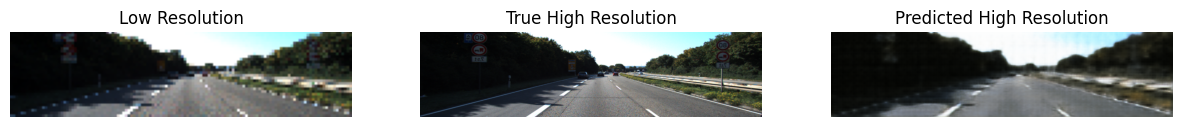


Sample Prediction after epoch 10

100/100 [==============================] - 2s 23ms/step - loss: 0.0449
Epoch 11/20
100/100 [==============================] - ETA: 0s - loss: 0.0472

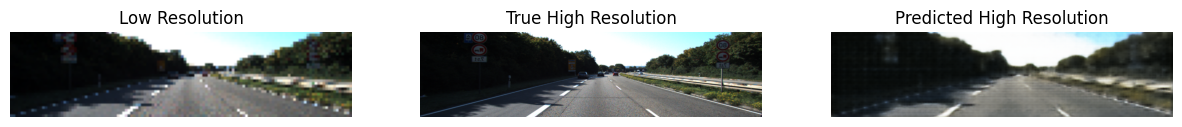


Sample Prediction after epoch 11

100/100 [==============================] - 2s 23ms/step - loss: 0.0472
Epoch 12/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0434

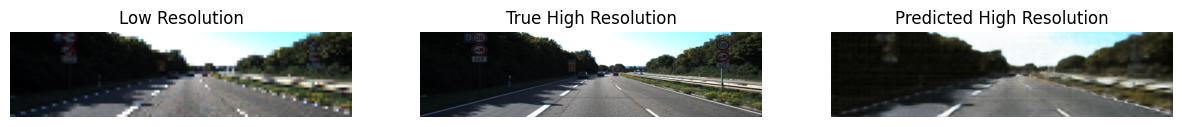


Sample Prediction after epoch 12

100/100 [==============================] - 2s 23ms/step - loss: 0.0433
Epoch 13/20
100/100 [==============================] - ETA: 0s - loss: 0.0425

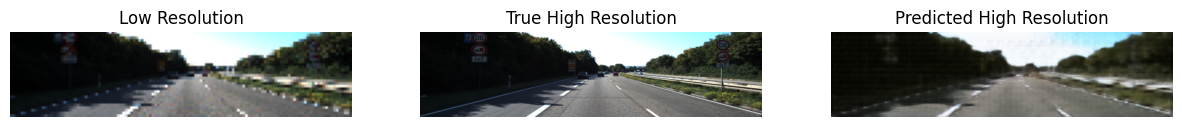


Sample Prediction after epoch 13

100/100 [==============================] - 2s 23ms/step - loss: 0.0425
Epoch 14/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0418

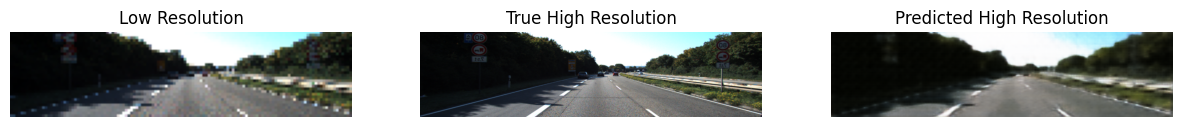


Sample Prediction after epoch 14

100/100 [==============================] - 2s 23ms/step - loss: 0.0419
Epoch 15/20
100/100 [==============================] - ETA: 0s - loss: 0.0409

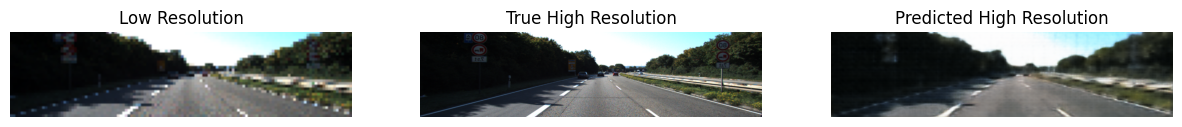


Sample Prediction after epoch 15

100/100 [==============================] - 2s 23ms/step - loss: 0.0409
Epoch 16/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0400

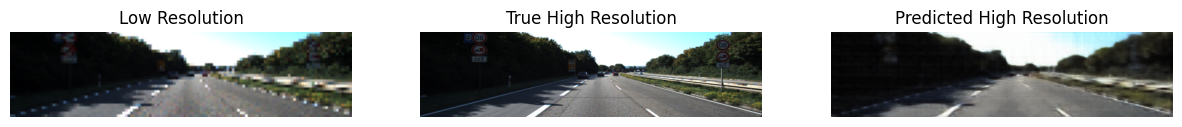


Sample Prediction after epoch 16

100/100 [==============================] - 2s 23ms/step - loss: 0.0399
Epoch 17/20
100/100 [==============================] - ETA: 0s - loss: 0.0394

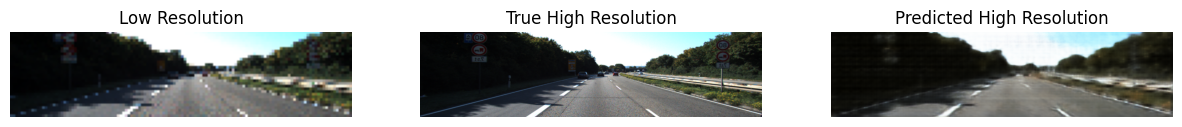


Sample Prediction after epoch 17

100/100 [==============================] - 2s 23ms/step - loss: 0.0394
Epoch 18/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0397

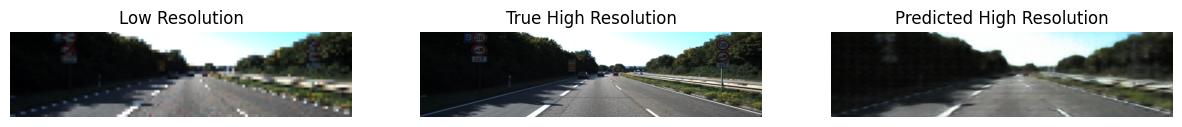


Sample Prediction after epoch 18

100/100 [==============================] - 2s 23ms/step - loss: 0.0396
Epoch 19/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0395

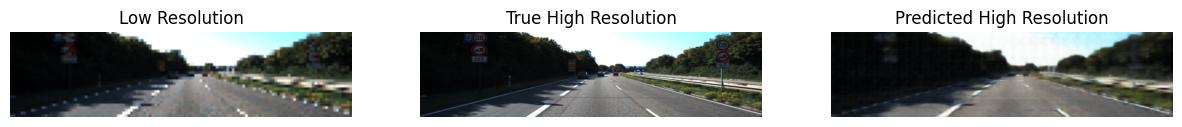


Sample Prediction after epoch 19

100/100 [==============================] - 2s 23ms/step - loss: 0.0395
Epoch 20/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0385

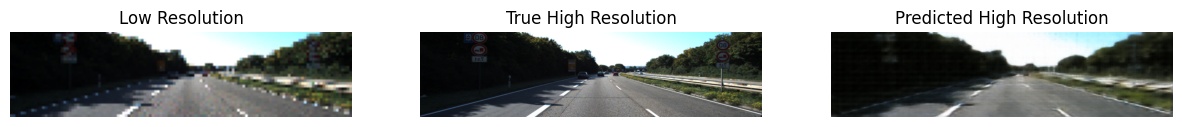


Sample Prediction after epoch 20


100/100 [==============================] - 2s 23ms/step - loss: 0.0382


In [19]:
EPOCHS = 20

model_history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0419

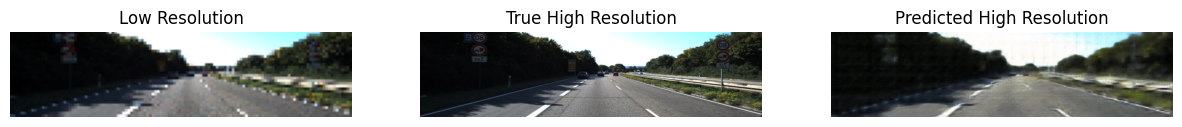


Sample Prediction after epoch 1

100/100 [==============================] - 3s 26ms/step - loss: 0.0419
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0388

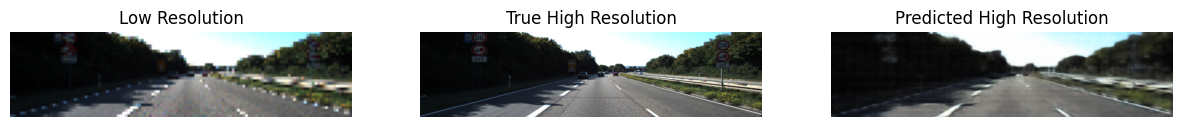


Sample Prediction after epoch 2

100/100 [==============================] - 2s 23ms/step - loss: 0.0388
Epoch 3/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0376

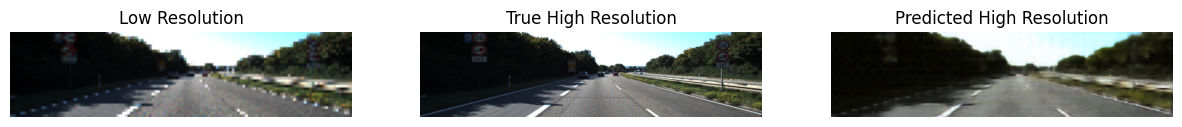


Sample Prediction after epoch 3

100/100 [==============================] - 2s 23ms/step - loss: 0.0377
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0422

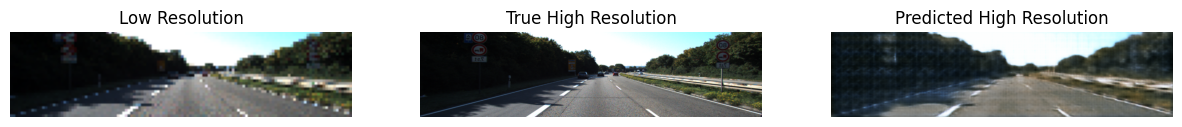


Sample Prediction after epoch 4

100/100 [==============================] - 2s 23ms/step - loss: 0.0422
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 0.0404

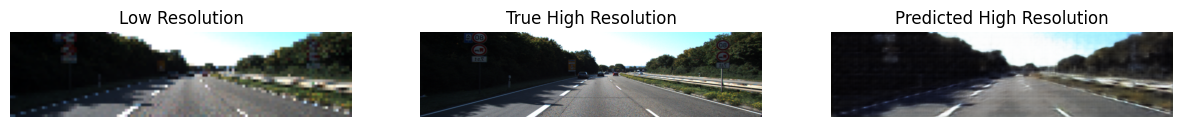


Sample Prediction after epoch 5

100/100 [==============================] - 2s 23ms/step - loss: 0.0404
Epoch 6/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0357

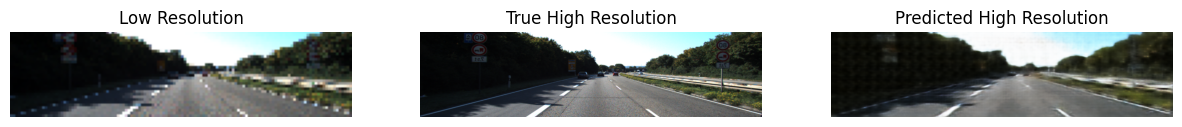


Sample Prediction after epoch 6

100/100 [==============================] - 2s 23ms/step - loss: 0.0357
Epoch 7/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0365

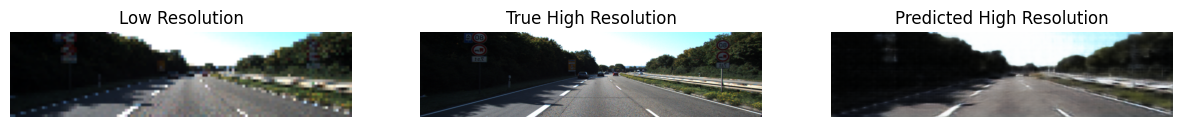


Sample Prediction after epoch 7

100/100 [==============================] - 2s 23ms/step - loss: 0.0363
Epoch 8/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0357

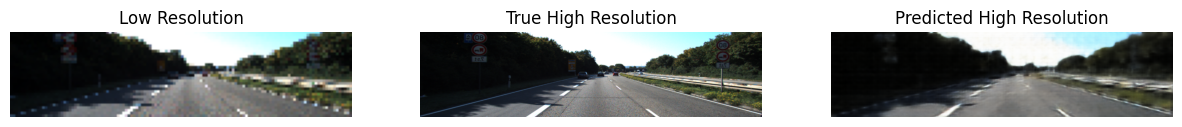


Sample Prediction after epoch 8

100/100 [==============================] - 2s 23ms/step - loss: 0.0356
Epoch 9/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0346

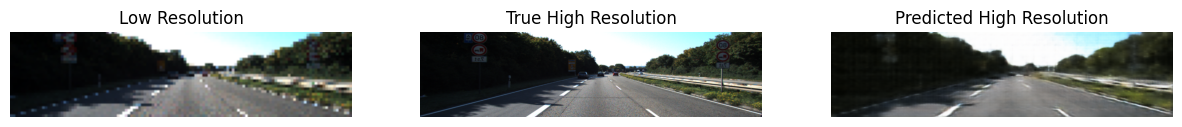


Sample Prediction after epoch 9

100/100 [==============================] - 2s 23ms/step - loss: 0.0345
Epoch 10/20
100/100 [==============================] - ETA: 0s - loss: 0.0358

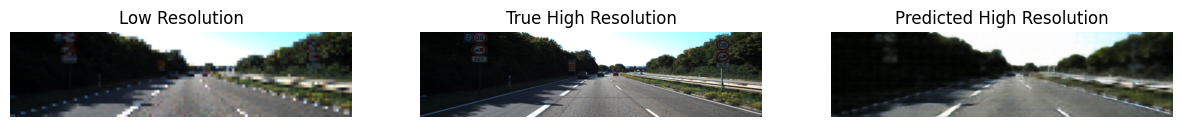


Sample Prediction after epoch 10

100/100 [==============================] - 2s 23ms/step - loss: 0.0358
Epoch 11/20
100/100 [==============================] - ETA: 0s - loss: 0.0375

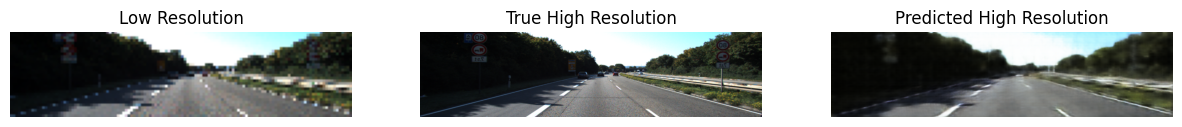


Sample Prediction after epoch 11

100/100 [==============================] - 2s 23ms/step - loss: 0.0375
Epoch 12/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0358

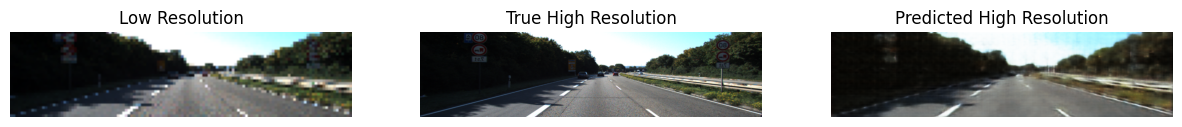


Sample Prediction after epoch 12

100/100 [==============================] - 2s 23ms/step - loss: 0.0359
Epoch 13/20
100/100 [==============================] - ETA: 0s - loss: 0.0341

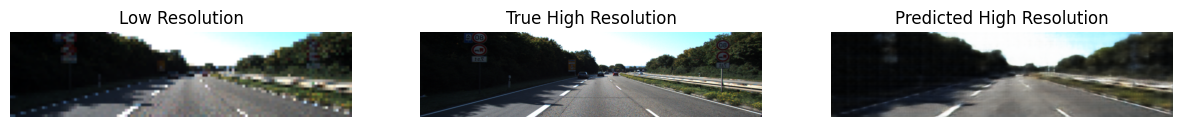


Sample Prediction after epoch 13

100/100 [==============================] - 2s 23ms/step - loss: 0.0341
Epoch 14/20
100/100 [==============================] - ETA: 0s - loss: 0.0324

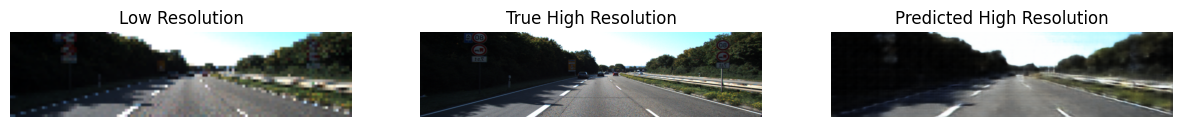


Sample Prediction after epoch 14

100/100 [==============================] - 2s 23ms/step - loss: 0.0324
Epoch 15/20
100/100 [==============================] - ETA: 0s - loss: 0.0326

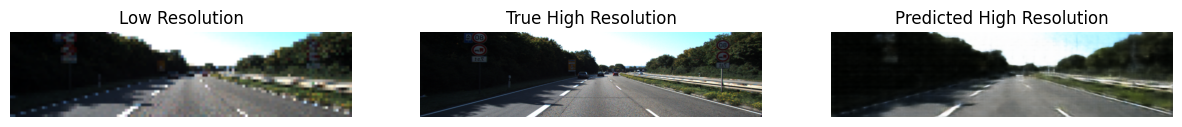


Sample Prediction after epoch 15

100/100 [==============================] - 2s 23ms/step - loss: 0.0326
Epoch 16/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0323

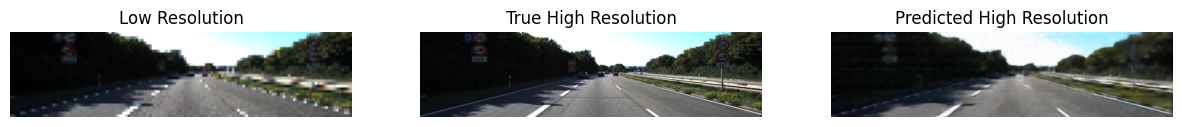


Sample Prediction after epoch 16

100/100 [==============================] - 2s 23ms/step - loss: 0.0322
Epoch 17/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0324

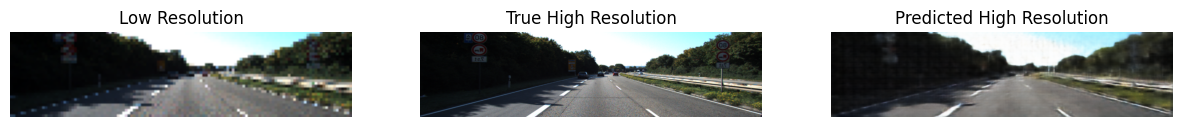


Sample Prediction after epoch 17

100/100 [==============================] - 2s 23ms/step - loss: 0.0323
Epoch 18/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0316

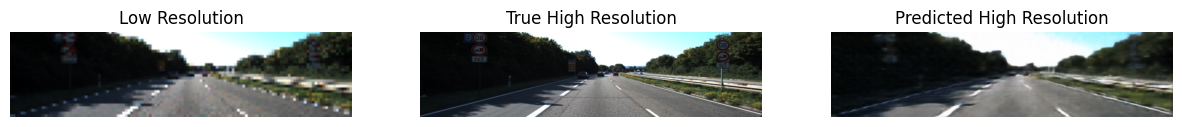


Sample Prediction after epoch 18

100/100 [==============================] - 2s 23ms/step - loss: 0.0317
Epoch 19/20
100/100 [==============================] - ETA: 0s - loss: 0.0318

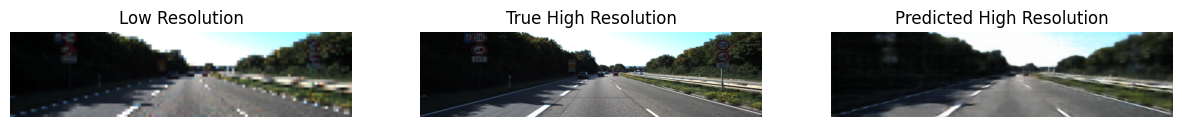


Sample Prediction after epoch 19

100/100 [==============================] - 3s 25ms/step - loss: 0.0318
Epoch 20/20
 98/100 [============================>.] - ETA: 0s - loss: 0.0299

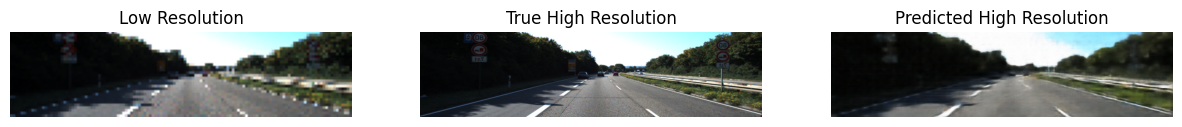


Sample Prediction after epoch 20


100/100 [==============================] - 2s 23ms/step - loss: 0.0303


In [20]:
tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

EPOCHS = 20

model_history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])

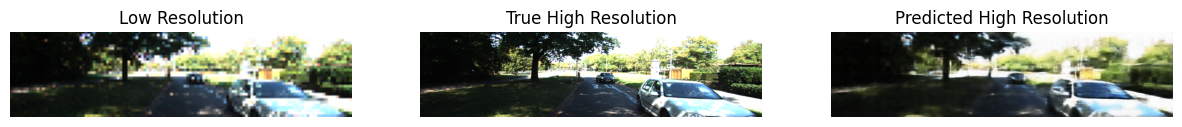

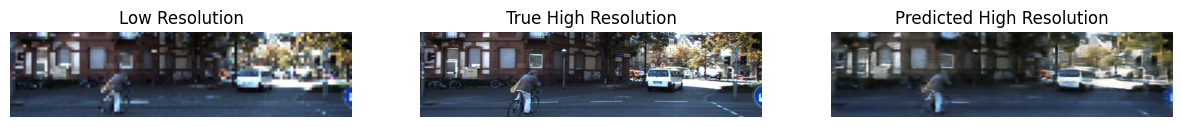

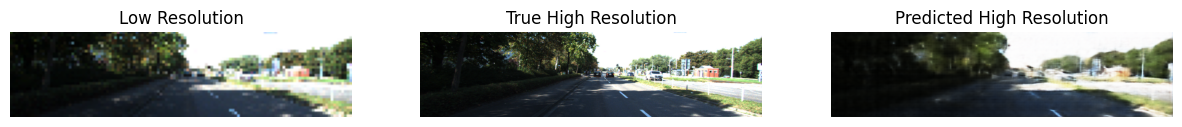

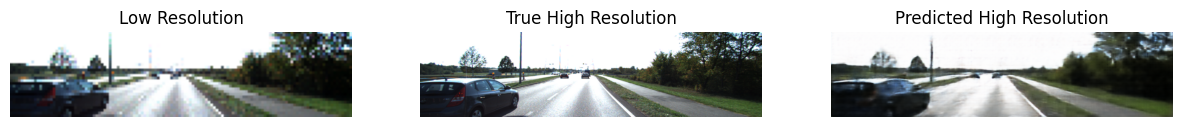

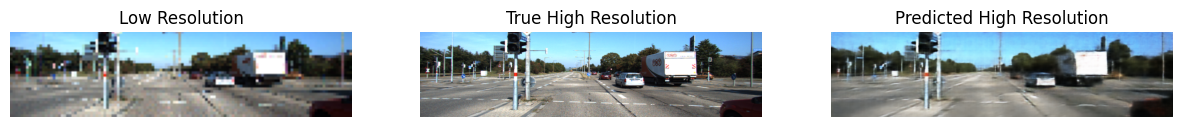

In [21]:
for low_res, high_res in train_dataset.take(5):
    predicted_image = model.predict(low_res)
    display([low_res[0], high_res[0], predicted_image[0]])

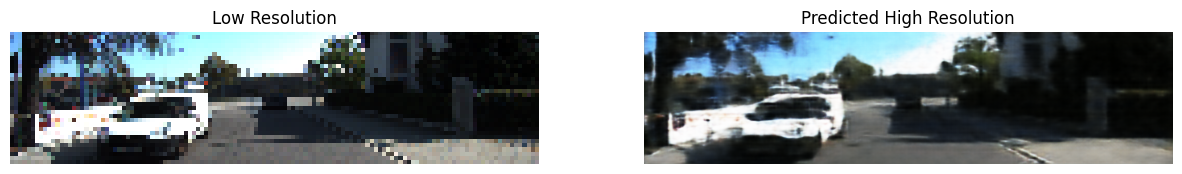

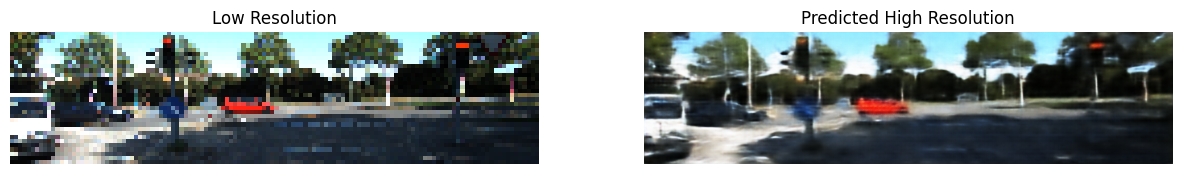

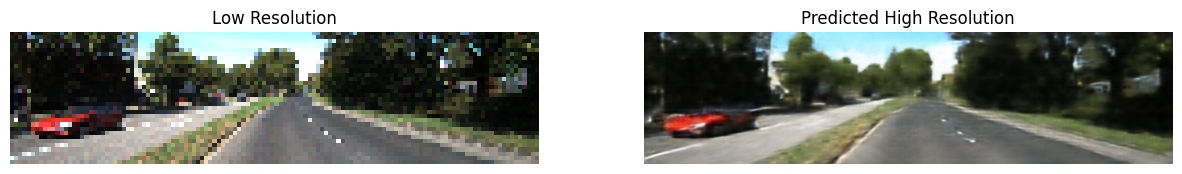

In [22]:
# monitor
def display2(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Low Resolution', 'Predicted High Resolution']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            
        plt.axis('off')
    plt.show()

for low_res, _ in test_dataset.take(5):
    predicted_image = model.predict(low_res)
    display2([low_res[0], predicted_image[0]])